***
## **<center>Collaborative Filtering Recommender System on MovieLens 27M</center>**

### <center> **Data Preprocessing / Exploration, Model Training & Results</center>**

**<center>Télécom Paris | MS Big Data | SD 701: Big Data Mining </center>**
***

<br>

This notebook summarizes results from a collaborative filtering recommender system implemented with Spark MLlib: how well it scales and fares (for generating relevant user recommendations) on a new MovieLens 27,000,000 movie ratings dataset.

# **Configuration**

**Install Apache Spark on Colab**


In [ ]:
import os

The following installs Apache Spark (and its dependencies such as Java JDK 8) for use in Google Colab. Once the Google Colab Session terminates, the following cell must be run again.

In [2]:
# Download Java JDK Version 8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Download and Install Apache Spark (with Findspark)
!wget -q http://www-eu.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

# Change Java Version Frim JDK-11 to JDK-8
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode


**Launch Spark Session on Colab**

In [3]:
# Findspark for Jupyter Notebook (spark-2.4.4-bin-hadoop2.7)
import findspark
findspark.init()

# Start Apache Spark Session & Context
import pyspark
from pyspark.sql import SQLContext

sc = pyspark.SparkContext(appName='sd701-RecoSys-Models')
sqlContext = SQLContext(sc)

print('Master : ', sc.master)
print('Cores  : ', sc.defaultParallelism)

Master :  local[*]
Cores  :  2


In [ ]:
# Required Later
sqlContext.sparkSession.conf.set("spark.sql.autoBroadcastJoinThreshold", -1)

**Packages**

Only the following packages are available in Google Colab:

In [5]:
!pip install koalas

     |████████████████████████████████| 532kB 4.8MB/s 


In [ ]:
# Default Packages (available by Default in Google Colab)
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import random
from pprint import pprint
from matplotlib.lines import Line2D

# Downloaded Packages (not available by Default)
import databricks.koalas

# PySpark Utilities
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.mllib.evaluation import RegressionMetrics, RankingMetrics

# Random Seed
SEED = 1492

# Set-up
plt.style.use('seaborn')

**Link Google Colab to your personal Google Drive**

In [8]:
from google.colab import drive
drive.mount('/content/drive');

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Check data location on drive:

In [9]:
!ls "drive/My Drive/TELECOM_MS_BIG_DATA/COURSES/BIG DATA MINING/PROJECT/DATA"

MovieLens100K  MovieLens27M  Other


In [ ]:
# Path to Data Folder
DATA_PATH = "drive/My Drive/TELECOM_MS_BIG_DATA/COURSES/BIG DATA MINING/PROJECT/DATA/MovieLens27M/"

# Path to Results Folder
RESULTS_PATH = "drive/My Drive/TELECOM_MS_BIG_DATA/COURSES/BIG DATA MINING/PROJECT/RESULTS/"

# **1. Data Preprocessing**

***

We consider the following steps:

- Casting several string columns into integer columns (required for model training)
- Inserting personal IMDb ratings into MovieLens Ratings dataset
- For ranking accuracy evaluation : consider any movie rated over the grade of 3 as a relevant movie for the user (thus gets a 1). Otherwise it gets a 0.

In [ ]:
class MovieLensDatasets(object):
    """
    Class for loading and preprocesing MovieLens Dataset
    """
    def __init__(self, ratings, movies, links, personalRatings,
                 debug=True, debugLimit=10000):
    # Load Existing Data
    if debug:
        debugLimit = debugLimit
        ratings = ratings.limit(debugLimit)
    else:
        ratings = ratings      

    self.ratings = ratings
    self.movies = movies
    self.links = links
    self.personalRatings = personalRatings

    # Create New DataFrame
    users = ratings.select('userId').distinct()
    self.users = users

    def preprocessing(self):
    # Preprocess MovieLens Ratings
    self.ratings = self.ratings.withColumn('rating',
          F.col('rating').cast('double')).drop('timestamp') \
          .withColumn('userId', F.col('userId').cast('int')) \
          .withColumn('movieId', F.col('movieId').cast('int'))

    # Preprocess Personal IMDb Ratings To MovieLens Ratings
    self.personalRatings = self.personalRatings.select(['Const',
                                                    'Your Rating']) \
          .withColumnRenamed('Const', 'imdbId') \
          .withColumnRenamed('Your Rating', 'personalRating')

    self.personalRatings = self.personalRatings \
        .withColumn('personalRating', F.col('personalRating').cast('double')*0.5) \
        .withColumn('imdbId', F.expr("substr(imdbId, 3)"))

    self.personalRatings = self.personalRatings.join(
        self.links.select('movieId', 'imdbId'), ['imdbId'], how='inner')

    # Insert IMDb Ratings into MovieLens Ratings Dataset
    self.personalRatings = self.personalRatings \
                        .withColumn('userId', F.lit('0'))
    self.personalRatings = self.personalRatings \
                        .select(['userId', 'movieId', 'personalRating']) \
                        .toDF('userId', 'movieId', 'rating')
    self.ratings = self.ratings.union(self.personalRatings)

    # Binarize MovieLens Ratings (if rating >= 3.0, then 1.0, else 0.0)
    udf_scale_ratings = F.udf(lambda x: x - 2.5, DoubleType())
    udf_binary_ratings = F.udf(lambda x: 1.0 if x > 0.0 else 0.0, DoubleType())

    self.ratings = self.ratings \
    .withColumn('ratingsScaled', udf_scale_ratings(F.col('rating'))) \
    .withColumn('ratingsBinary', udf_binary_ratings(F.col('ratingsScaled')))

    def get_ratings(self):
        return self.ratings

    def get_movies(self):
        return self.movies

    # Displaying Null Values
    def spark_df_display_null_values(sparkDf):
        print('NaN values ?')
        sparkDf.select([F.count(F.when(F.isnan(c), c)).alias(c) for c in sparkDf.columns]).show()

        print('Null values ?')
        sparkDf.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in sparkDf.columns]).show()

Load data:

In [16]:
%%time
# Set to True if only testing
# For testing: use debug=True option (subset of all ratings)
debug = False

# Load Datasets
movies = sqlContext \
            .read.format('csv').option("header", "true") \
            .load(DATA_PATH + "movies.csv")

links = sqlContext \
            .read.format('csv').option("header", "true") \
            .load(DATA_PATH + "links.csv")

ratings = sqlContext.read \
            .format('csv').option("header", "true") \
            .load(DATA_PATH + "ratings.csv")

personalRatings = sqlContext \
            .read.format('csv').option("header", "true") \
            .load(DATA_PATH + "Personal_IMBD_Ratings.csv")


# Data Preprocessing
movieLensDatasets = MovieLensDatasets(ratings=ratings, movies=movies,
                                      links=links,
                                      personalRatings=personalRatings,
                                      debug=debug)

movieLensDatasets.preprocessing()
dfRatings = movieLensDatasets.get_ratings() 
dfMovies = movieLensDatasets.get_movies()

CPU times: user 26.2 ms, sys: 1.69 ms, total: 27.9 ms
Wall time: 1.58 s


# **2. Exploratory Data Analysis with Koalas**

Koalas is a Python library that provides a "Pandas-like API" on top of a Spark DataFrame.

[GitHub Repository of Koalas](https://github.com/databricks/koalas)

In [ ]:
dfRatingsKdf = dfRatings.to_koalas()

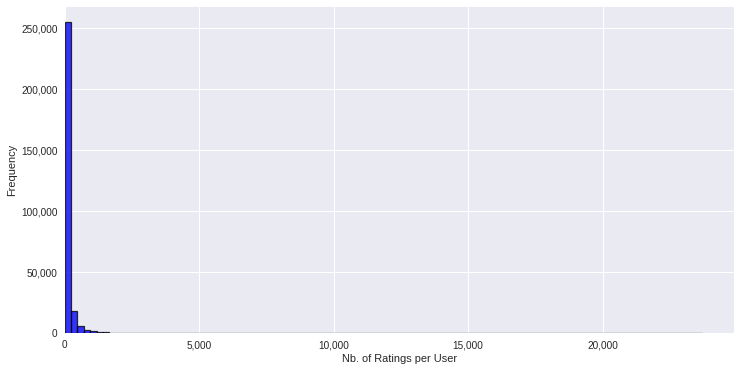

CPU times: user 499 ms, sys: 39.8 ms, total: 539 ms
Wall time: 2min 4s


In [ ]:
%%time
f, ax = plt.subplots(figsize=(12,6))
userRatingGroup = dfRatingsKdf.groupby("userId")['rating'].count()
userRatingGroup.hist(bins=100, color='blue', edgecolor='black',
                     linewidth=1.25, alpha=0.78, ax=ax)
ax.set_xlabel('Nb. of Ratings per User')
ax.set_xlim(0.0)
ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks().tolist()])
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
plt.show()

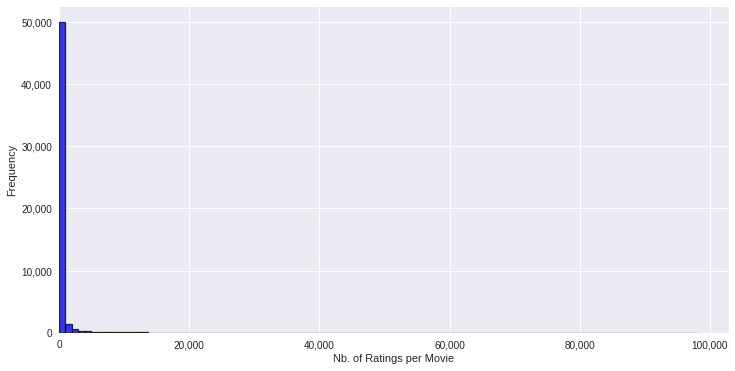

CPU times: user 482 ms, sys: 22.5 ms, total: 504 ms
Wall time: 1min 46s


In [ ]:
%%time
f, ax = plt.subplots(figsize=(12,6))
movieRatingGroup = dfRatingsKdf.groupby("movieId")['rating'].count()
movieRatingGroup.hist(bins=100, color='blue', edgecolor='black',
                      linewidth=1.25, alpha=0.78, ax=ax)
ax.set_xlabel('Nb. of Ratings per Movie')
ax.set_xlim(0.0)
ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks().tolist()])
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
plt.show()

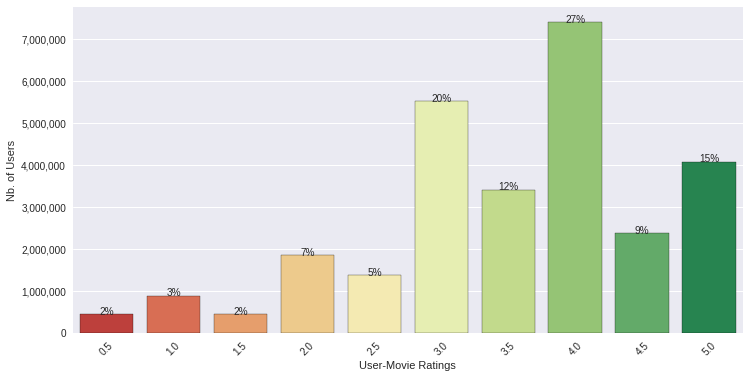

CPU times: user 439 ms, sys: 16 ms, total: 455 ms
Wall time: 44.3 s


In [ ]:
%%time
movieRatingDistGroup = dfRatingsKdf['rating'].value_counts() \
                                             .sort_index() \
                                             .reset_index() \
                                             .to_pandas()

# Create Matplotlib Figure
fig, ax = plt.subplots(figsize=(12,6))

# Main Figure: Seaborn Barplot
sns.barplot(data=movieRatingDistGroup, x='index', y='rating',
            palette='RdYlGn', edgecolor="black", ax=ax)

# Set Xaxis and Yaxis
ax.set_xlabel("User-Movie Ratings")
ax.set_ylabel('Nb. of Users')
ax.xaxis.set_tick_params(rotation=45)

# Thousand separator on Yaxis labels
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

# Add percentage text on top of each bar
total = float(movieRatingDistGroup['rating'].sum())
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+350,
            '{0:.0%}'.format(height/total),
            ha="center") 

# Display plot
plt.show()

Inspired by [Recmetrics](https://github.com/statisticianinstilettos/recmetrics/blob/master/recmetrics/plots.py) and adapted to Spark Koalas:

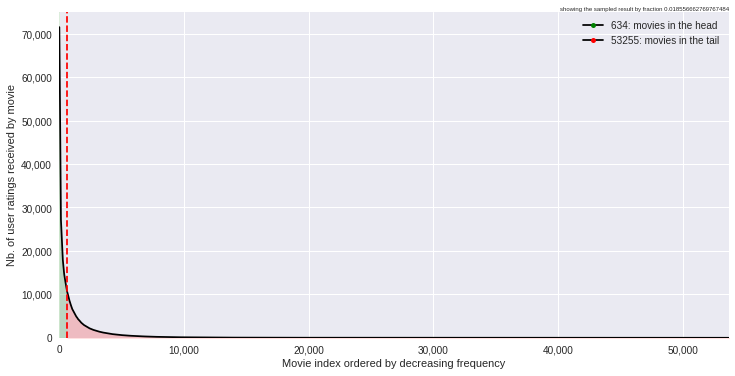

CPU times: user 1.17 s, sys: 110 ms, total: 1.28 s
Wall time: 6min 36s


In [ ]:
%%time
f, ax = plt.subplots(figsize=(12,6))

# Calculate Cumulative Volumes
item_id_column = "movieId"
volume_df = dfRatingsKdf[item_id_column].value_counts().reset_index()
volume_df.columns = [item_id_column, "volume"]
volume_df[item_id_column] = volume_df[item_id_column].astype(str)
volume_df['cumulative_volume'] = volume_df['volume'].cumsum()
volume_df['percent_of_total_volume'] = \
    volume_df['cumulative_volume']/volume_df['volume'].sum()

# Main
temp = volume_df['volume']
temp.plot(kind='line', ax=ax, color='black')

ax.set_xlim(-15)
ax.set_ylim(0.0)
ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks().tolist()])
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
ax.set_xlabel('Movie index ordered by decreasing frequency')
ax.set_ylabel('Nb. of user ratings received by movie')

# Plot vertical line at the tail location
percentage = 0.5
head = volume_df[volume_df.percent_of_total_volume <= percentage]
tail = volume_df[volume_df.percent_of_total_volume > percentage]
items_in_head = len(head)
items_in_tail = len(tail)

plt.axvline(x=items_in_head, color="red",  linestyle='--')

# Legend
legend_elements = [Line2D([0], [0], marker='o', color='black',
                          label=str(items_in_head)+': movies in the head',
                          markerfacecolor='green', markersize=5),
                    
                    Line2D([0], [0], marker='o', color='black',
                          label=str(items_in_tail)+': movies in the tail',
                          markerfacecolor='red', markersize=5)]
ax.legend(handles=legend_elements, loc=1)

# Fill area under plot
head = head.append(tail.head(1))
x1 = head.index.to_pandas().to_numpy() # => changes here from original code
y1 = head['volume'].to_pandas()        # => changes here from original code
x2 = tail.index.to_pandas().to_numpy() # => changes here from original code
y2 = tail['volume'].to_pandas()        # => changes here from original code
ax.fill_between(x1, y1, color="green", alpha=0.2)
ax.fill_between(x2, y2,  color="red", alpha=0.2)

plt.show()

# **3. Model Training**
***

## **3.1. Train / Test Set Split**

In [ ]:
ratingsPrepare = dfRatings.withColumn("userId", F.col("userId").cast('int')) \
                          .withColumn("movieId", F.col("movieId").cast('int'))

dfRatingsTrain, dfRatingsTest = ratingsPrepare.randomSplit([0.8, 0.2],
                                                           seed=SEED)

## **3.2. Metrics**

Our main goal is to evaluate the *soundness of items recommended by our recommenders systems*. This requires the use of ranking metrics as they are well-suited to this task. Spark ML doesn't provide functions for computing those ranking metrics. They are only available in [Spark MLlib](https://spark.apache.org/docs/2.2.0/mllib-evaluation-metrics.html#ranking-systems) which relies on Resilient Distributed Datasets (RDD) instead of DataFrames.

<br>

**Explanation**

The following metrics implemented in Spark MLlib only work if you treat the recommender system problem as binary: either the algorithm recommended a relevant item or it didn't. It does it through a relevance function.

Suppose a user has a list of loved movies $D = \{ d_1, ..., d_{N} \}$ (we follow Spark's documented examples and consider that any movie rated over 3 will be deemed relevant). Now our recommender system generated a list of $Q$ movie items $Z=\{z_1, ..., z_{Q}\}$. We judge that an item $m$ relevant if:

<br>

$$ rel_D(z) = \begin{cases}
             1  & \text{if } z \in D \\
             0  & \text{else}
       \end{cases} $$

<br>

##### **Precision at rank $k$**

Measures (on average for all users) the number of $k$ user-recommended items that are relevant to the user (given his past rating behavior of movies he liked or dislike). The actual ranking of items recommended is not considered.

<br>

$$ p(k) = \frac{1}{M} \sum_{i=0}^{M-1} \frac{1}{k} \sum_{j=0}^{\min(|D|,k)-1} rel_{D_i}(Z_i(j)) $$


<br>

##### **Normalized Discounted Cumulative Gain at rank $k$**

Similar to precision, only this time the actual order of recommended items is taken into consideration during evaluation.

<br>

$$ NDCG(k) = \frac{1}{M} \sum_{i=0}^{M-1} \frac{1}{IDCG(D_i,k)} \sum_{j=0}^{n-1} \frac{rel_{D_i}(Z_i(j))}{\ln(j+1)}$$

$$ n =\min (\max(|Z_i|, |D_i|, k)), \qquad IDCG(D,k) = \sum_{j=0}^{\min(|D|,k)-1} \frac{1}{\ln(j+1)} $$

<br>

##### **Root Mean-Squared Error**

RMSE will also be reported which is only relevant for collaborative filtering with latent factor models (as it attempts to reconstruct ratings and uses it as it cost function during optimization).

<br>

$$ RMSE = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat y_i )^2 $$

<br>

##### **Catalog Coverage**

Implementation from [recmetrics](https://github.com/statisticianinstilettos/recmetrics/blob/master/recmetrics/metrics.py) package.

Measures the percentage of movies that are recommended for at the bare minimum one user. Essentially, it tells you how many items of the entire 58,000 movie catalog are actually recommended to our $m$ users by the algorithm. There is a trade-off between between generating relevant recommendations and covering most of the available pool of items.

<br>

$$ CC = \frac{|\cup_{u=1}^m T_u|}{n} $$

<br>

In [ ]:
### Accuracy Metrics
def catalog_coverage(predicted, catalog, k):
    """
    Computes the catalog coverage for k lists of recommendations
    Parameters
    ----------
    predicted : a list of lists
        Ordered predictions
        example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
    catalog: list
        A list of all unique items in the training data
        example: ['A', 'B', 'C', 'X', 'Y', Z]
    k: integer
        The number of observed recommendation lists
        which randomly choosed in our offline setup
    Returns
    ----------
    catalog_coverage:
        The catalog coverage of the recommendations as a percent
        rounded to 2 decimal places
    ----------    
    Metric Defintion:
    Ge, M., Delgado-Battenfeld, C., & Jannach, D. (2010, September).
    Beyond accuracy: evaluating recommender systems by coverage and
    serendipity.
    In Proceedings of the fourth ACM conference on Recommender systems
    (pp. 257-260). ACM.
    """
    sampling = random.choices(predicted, k=k)
    predicted_flattened = [p for sublist in sampling for p in sublist]
    L_predictions = len(set(predicted_flattened))
    catalog_coverage = L_predictions/(len(catalog)*1.0)
    return catalog_coverage


def get_rec_sys_results(relevantDocumentsDf, dfMovies):
    """
    Returns dictionnary of recommender system metrics
    Since Spark ML DataFrame-based doesn't have a
    specific function for evaluating the soundness
    of item recommendations, we will have to use
    Spark MLlib RDD-based API
    """
    # Transform Spark Dataframe into Spark RDD
    relevantDocuments = relevantDocumentsDf.rdd \
        .map(lambda row: (row.predictions, row.groundTruth))
    
    # Get Catalog Coverage
    moviesCatalog = dfMovies.select("movieId") \
                            .orderBy("movieId") \
                            .distinct() \
                            .toPandas()
    predictions = relevantDocumentsDf.select("predictions").toPandas()
    predictionsList = predictions.values.tolist()
    predictionsList = [sublist[0] for sublist in predictionsList]
    cc = catalog_coverage(predicted=predictionsList,
                          catalog=moviesCatalog, k=100)

    # Get Results
    metrics = RankingMetrics(relevantDocuments)
    pk20 = metrics.precisionAt(20)
    ndcg20 = metrics.ndcgAt(20)
    
    results = dict(Pk20=pk20, NDCGk20=ndcg20, CC=cc)
    
    return results


def format_recommendations(rowPreds):
    # From recommendations column extract only items
    # recommended and ignore ratings
    rowPredsList = [row.movieId for row in rowPreds]
    return rowPredsList

udf_format_recommendations = F.udf(lambda x: format_recommendations(x),
                                   ArrayType(IntegerType()))

## **3.3. Popularity-Based Model**

The easiest approach for recommending movies is to simply recommend the most popular ones. This simple approach will act as a benchmark for more complex machine learning models.

We will mesure movie popularity here by the average user rating for a given movie. We previously used in our Exploratory Data Analysis notebook the following heuristic:

<br>

$$ \mathbf{R} = (R_1, R_2, ..., R_n), \qquad |\mathbf{R}| = n$$

$$ g(m) = \frac{1}{|\mathbf{R}|} \sum_{r\in \mathbf{R}} r, \qquad \tilde g(m) = \log{|\mathbf{R}|} \cdot g(m) $$

<br>

which computes the mean rating for movie while ensuring through a logarithmic scalar that prevents obscure movies from being ranked higher than movies with a much larger viewer reach and thus were rated far more often.

In [ ]:
class PopularityRecommenderModel(object):
    """
    Class for generating movie item recommendations based on movie popularity
    (from average ratings with logarithmic scaling factor that penalizes movies
    with few ratings). By default, only the top 10 rated movies are selected.

    Approach studied during MS Big Data's SD 701 Big Data Mining Course.
    """
    def __init__(self, ratingsTrain, ratingsTest):
        self.ratingsTrain = ratingsTrain
        self.ratingsTest = ratingsTest

    def generate_recommendations_for_all_users(self, topk=10):
        # Get list of top k rated movies
        topRated = self._get_top_k_best_movies(topk=topk)

        # Compare most popular movies with user's personal preferences
        # Important: only keep recommendations with rating over 3/5
        results = self.ratingsTest \
                 .filter(F.col("ratingsBinary")==1.0) \
                 .withColumn('movieId', F.col('movieId').cast('int')) \
                 .orderBy('rating', ascending=False) \
                 .groupby("userId") \
                 .agg(F.collect_list("movieId").alias('groundTruth')) \
                 .withColumn('predictions', F.array([F.lit(el)
                        for el in topRated])) \
                 .select(['userId', 'predictions', 'groundTruth'])

        return results

    def _get_top_k_best_movies(self, topk):

    # Function
    def _get_mean_rating_w_log_penalty(arr):
        sumRatings, nbRatings = arr[0], arr[1]
        grade = (sumRatings / nbRatings) * math.log(nbRatings)
    return grade

    # UDF
    udf_mean_rating_w_log_penalty = F.udf(
        lambda arr: _get_mean_rating_w_log_penalty(arr),
        DoubleType()
    )

    # Get top k Best Rated Movies
    ranking = self.ratingsTrain.groupBy('movieId') \
              .agg({'rating': 'sum', 'userId': 'count'}) \
              .toDF('movieId', 'sumRating', 'nbRatings')

    ranking = ranking \
      .withColumn("meanLogUserRating",
         udf_mean_rating_w_log_penalty(F.array("sumRating", "nbRatings"))
         ) \
      .sort(['meanLogUserRating', 'nbRatings'], ascending=[False, True]) \
      .limit(topk)

    self.topRatedMovies = ranking
    ratingsTop = [int(row.movieId) for row in ranking.collect()]

    return ratingsTop

<br>

Let's generate recommendations for each user based on our **popularity model**:

In [ ]:
%%time
pbrModel = PopularityRecommenderModel(dfRatingsTrain, dfRatingsTest)
resultsPop = pbrModel.generate_recommendations_for_all_users(topk=20)

CPU times: user 67.5 ms, sys: 11.3 ms, total: 78.8 ms
Wall time: 2min 13s


In [ ]:
%%time
resultsPop.limit(5).orderBy('userId').show(5)

+------+--------------------+--------------------+
|userId|         predictions|         groundTruth|
+------+--------------------+--------------------+
|   148|[318, 296, 858, 5...|[32, 36, 661, 837...|
|   463|[318, 296, 858, 5...|[431, 593, 872, 720]|
|   471|[318, 296, 858, 5...|[3252, 3967, 7147...|
|   496|[318, 296, 858, 5...|         [3624, 804]|
|   833|[318, 296, 858, 5...|[475, 1287, 3256,...|
+------+--------------------+--------------------+

CPU times: user 50 ms, sys: 10.1 ms, total: 60.1 ms
Wall time: 4min 11s


In [ ]:
%%time
results = get_rec_sys_results(resultsPop, dfMovies)

CPU times: user 3.03 s, sys: 172 ms, total: 3.2 s
Wall time: 8min 54s


In [ ]:
pprint(results)

{'CC': 0.00034424592929188614,
 'NDCGk20': 0.08245820681012826,
 'Pk20': 0.049648024344496444}


Highest rated movies:

In [ ]:
%%time
_ = pbrModel.generate_recommendations_for_all_users(topk=20)
pbrModel.topRatedMovies \
    .join(dfMovies.select(['movieId', 'title']), 'movieId') \
    .orderBy('meanLogUserRating', ascending=False) \
    .show(20, truncate=False)

+-------+---------+---------+------------------+------------------------------------------------------------------------------+
|movieId|sumRating|nbRatings|meanLogUserRating |title                                                                         |
+-------+---------+---------+------------------+------------------------------------------------------------------------------+
|318    |347016.0 |78423    |49.86835604478385 |Shawshank Redemption, The (1994)                                              |
|296    |308882.0 |74013    |46.791560381148095|Pulp Fiction (1994)                                                           |
|858    |210826.0 |48639    |46.77876482835748 |Godfather, The (1972)                                                         |
|527    |243831.0 |57304    |46.618789047520316|Schindler's List (1993)                                                       |
|50     |213594.5 |49783    |46.403714424803205|Usual Suspects, The (1995)                              

## **3.4. Model-Based Collaborative Filtering**

**Collaborative filtering**

Such an approach generates recommendations for users by finding other users with similar tastes and hopefully help should those similar users display more varied tastes. CF models are thus completely agnostic of item characteristics, circumventing the need for hand-engineering of features (in contrast to content-based recommender systems). Such model recommendations for users are likely to generate more varied tastes and allow for a user to explore outside of his own usual preferences. Obscure movies however are likely to be ignored.

<br>

**Matrix Factorization**

There exists a number of techniques for implementing CF models. One such method is matrix factorization. Suppose we express our user data as a user-item ratings matrix $R\in\mathbb{R}^{m\times n}$ with $m$ users and $n$ items (movies here) where $R_{i,j}$ denotes a user $i$'s rating for movie $j$. We wish to express this matrix $R$ in a lower dimension product of 2 matrices $U\in\mathbb{R}^{m\times d}$ and $V\in\mathbb{R}^{n\times d}$, a more informative latent structure hidden in the data (e.g. large-scale identification of user similarities) for our recommender system. In order to find this latent structure, we need to minimize the following criterion:

<br>

$$ \min_{U\in\mathbb{R}^{m \times d},V\in\mathbb{R}^{n\times d}} \sum_{i,j} (R_{i,j} - \langle U_i,V_j \rangle)^2$$

<br>

One major challenge of collaborative filtering is data sparcity: as we saw in our Exploratory Data Analysis, the average viewer only watches an infinitesimal amount of films from the available pool of ones. Our ratings matrix $R$ is thus full of missing values.

<br>

**Alternating Least Squares**

This is actually a well-studied problem in the machine learning research community. A highly popular approach is *Weighted Regularization Alternating Least Squares* (ALS-WR). Briefly: 

- Can easily be distributed (similarly to *Stochastic Gradient Descent*)
- Prevents overfitting through Tikhonov regularization
- Can easily ignore missing entries (unlike SGD)
- Crucially compared to SGD, it displays faster convergence

<br>

$$ \min_{U\in\mathbb{R}^{m \times d},V\in\mathbb{R}^{n\times d}} \sum_{(i,j)|R_{i,j}\neq 0} (R_{i,j} - \langle U_i,V_j \rangle)^2 + \lambda \cdot\Bigl(\sum_i n_{u_i}\| U_i \|^2 + \sum_j n_{v_j}\| V_j \|^2\Bigl)  $$

<br>

### **a) Model Training**

An implementation of this algorithm is available in Spark ML.

In [19]:
%%time
tempALS = ALS(maxIter=10, rank=10, regParam=0.1, nonnegative=True,
              userCol='userId', itemCol='movieId', ratingCol='rating',
              coldStartStrategy='drop', implicitPrefs=False, seed=SEED)

mlALSFitted = tempALS.fit(dfRatingsTrain)

CPU times: user 96.3 ms, sys: 39.7 ms, total: 136 ms
Wall time: 4min 52s


In [ ]:
mlALSFitted.save(RESULTS_PATH+"ALS_MovieLens_27M")

In [ ]:
mlALSFitted = ALSModel.load(RESULTS_PATH+"ALS_MovieLens_27M")

### **b) RMSE**

**RMSE on Test Set**

In [20]:
%%time
predictions = mlALSFitted.transform(dfRatingsTest)
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating',
                                predictionCol='prediction')
rmse = evaluator.evaluate(predictions)
print('RMSE (Test Set):', rmse)

RMSE (Test Set): 0.8230623329491311
CPU times: user 81 ms, sys: 23.5 ms, total: 105 ms
Wall time: 2min 16s


### **c) Evaluating Recommendations**

In [ ]:
resultsALS = mlALSFitted.recommendForAllUsers(20)

resultsALS = resultsALS.withColumn('recommendations',
              udf_format_recommendations(F.col("recommendations"))) \
              .toDF('userId', 'predictions')

Most frequently recommended movies (for our test set):

In [ ]:
resultsALSExpanded = resultsALS \
                        .withColumn("movieId", F.explode("predictions")) \
                        .drop('predictions') \
                        .join(dfMovies, "movieId")

resultsALSKdf = resultsALSExpanded.to_koalas()

MostRecommendedMoviesForAllUsers = resultsALSKdf.groupby(["movieId", "title"])['userId'].count()
MostRecommendedMoviesForAllUsers = MostRecommendedMoviesForAllUsers.sort_values(ascending=False)

In [26]:
%%time
MostRecommendedMoviesForAllUsers.head(20)

CPU times: user 4.71 ms, sys: 0 ns, total: 4.71 ms
Wall time: 39.3 ms


movieId  title                                                      
151989   The Thorn (1971)                                               261925
177209   Acı Aşk (2009)                                                 252044
183947   NOFX Backstage Passport 2                                      194317
159761   Loot (1970)                                                    191602
185659   Macho Madness - The Randy Savage Ultimate Collection (2009)    190214
157789   .hack Liminality In the Case of Yuki Aihara                    189175
157791   .hack Liminality In the Case of Kyoko Tohno                    188893
184299   Freedom on My Mind (1994)                                      181605
165689   Head Trauma (2006)                                             143214
192089   National Theatre Live: One Man, Two Guvnors (2011)             133882
144202   Catch That Girl (2002)                                         127746
187129   Good Bye, Till Tomorrow (1960)                       

For every user, let's verify if the CF-ALS recommendations are consistent with the user's tastes:

In [ ]:
resultsALS = resultsALS \
                 .join(
                 dfRatingsTest \
                 .filter(F.col("ratingsBinary")==1.0) \
                 .withColumn('movieId', F.col('movieId').cast('int')) \
                 .groupby("userId") \
                 .agg(F.collect_list("movieId").alias("groundTruth")),
                     'userId'
                 )

# resultsALS.orderBy('userId').limit(10).show(10)

In [28]:
%%time
resultsALSMetrics = get_rec_sys_results(resultsALS, dfMovies)

CPU times: user 2.93 s, sys: 257 ms, total: 3.18 s
Wall time: 35min 4s


In [30]:
pprint(resultsALSMetrics)

{'CC': 0.004492409377259114,
 'NDCGk20': 2.5351364917954605e-06,
 'Pk20': 1.5632327653587634e-06}


## **3.5. Results**

**Performance Evaluation (Testing Set)**

In [ ]:
results = {'CC': 0.00034424592929188614,
           'NDCGk20': 0.08245820681012826,
           'Pk20': 0.049648024344496444}

In [ ]:
results['RMSE'] = 'N/A'
resultsALSMetrics['RMSE'] = rmse

In [33]:
modelResults = pd.DataFrame([results, resultsALSMetrics],
                             index=['PopRec', 'CF-ALS'])

modelResults.transpose()

,PopRec,CF-ALS
CC,0.000344246,0.00449241
NDCGk20,0.0824582,2.53514e-06
Pk20,0.049648,1.56323e-06
RMSE,N/A,0.823062


**Personalized Recommendations from CF-ALS for Myself**

In [34]:
%%time
dfRatingsTrain.filter(F.col("userId")==0).count()

CPU times: user 27.6 ms, sys: 6.98 ms, total: 34.6 ms
Wall time: 1min 52s


468

In [35]:
%%time
predictionsPerso = resultsALS.filter(F.col("userId")==0) \
                             .select(F.explode("predictions") \
                             .alias("movieId")) \
                             .join(dfMovies.select(["movieId", "title"]),
                                   "movieId") \
                             .join(dfRatings.filter(F.col("userId")==0),
                                   ['movieId'], how='left')

predictionsPerso.select(["title", "rating"]).show(10, truncate=False)

+-------------------------------------------------------------------------------------------+------+
|title                                                                                      |rating|
+-------------------------------------------------------------------------------------------+------+
|Head Trauma (2006)                                                                         |null  |
|Power of Grayskull: The Definitive History of He-Man and the Masters of the Universe (2017)|null  |
|8 Murders a Day (2011)                                                                     |null  |
|The Thorn (1971)                                                                           |null  |
|I'll Take You There (1999)                                                                 |null  |
|Dial H-I-S-T-O-R-Y (1997)                                                                  |null  |
|.hack Liminality: In the Case of Mai Minase                                               

## **3.6. Interpretation**

At first glance, our results with our first approach model-based collaborative filtering are mixed. The RMSE on the testing set is 0.0823 which is close to a benchmark result seen in this [arXiv research paper](https://arxiv.org/abs/1606.07659) on a different MovieLens dataset (with 20 million ratings). However, precision and NDCG (for the first 20 recommended items) for CF-ALS on the testing set are a low 0.0003\% and 0.0002\% respectively. Our popularity model outperforms CF-ALS significantly on both those metrics. Finally as shown with catalog coverage, both models struggle to recommend most of the available pool of movies to users.

One reason why our collaborative filtering model underperforms on precision and NDCG is that accuracy-based metrics are biased in favor of popular items. Our catalog coverage showed that CF-ALS produced more diverse recommendations on average then the popularity-based model. But as the vast majority of movies are almost never rated (known as the long tail of items), CF-ALS has much weaker accuracy as it generates more diverse but less relevant item recommendations (which might be more appealing than recommending the same popular movies).

One reason might be that the missing entries (here unrated movies) in our ratings interaction matrix $R$ are actually Missing Not At Random (MNAR): as users can watch any movie they want, the probability of a rating being missing is not at random. Thus, the ratings distribution on the highest rated movies are different from the ratings distribution of movies on the long tail (vast majority). It might be more ideal to compute accuracy metrics separately for the most popular movies and the rest of the movie catalog.

# **4. Potential Improvements**

For improving the accuracy and interpretability of our collaborative filtering algorithm, we will consider the following improvements:

- **Hybrid recommender systems**: the major weakness of collaborative filtering is that by  forgoing the actual characteristics of items (for movies, meta-information such as genres, actor/actresses, director, country of origin) hurts both recommender accuracy and interpretability of recommendations. In practice, industrial recommender systems use hybrid approaches that combine both user similarity (collaborative filtering) and item characteristics (content-based approach). There exists a Python implementation of such a hybrid approach known as LightFM which merits exploration ([LightFM Research Paper](http://ceur-ws.org/Vol-1448/paper4.pdf)).

- **Reducing dataset size and user-item segmentation**: one reason why our collaborative filtering model struggled to generate sound recommendations for all users is that our model training included every user (e.g. single rating users, users with few ratings or many ratings). A more ideal strategy would be to segment our ratings data into seperate but homogeneous user datasets and train different recommender systems on those separate data chunks, potentially improving our results.